📘  — 0. Setup inicial
En esta sección realizaremos la configuración básica del entorno de trabajo. Esto incluye:

Intalaciones de herramientas

Importación de todas las dependencias y utilidades

Carga y descompresion del dataset desde la ruta del drive, en esta parte se verifica que si esta descomprimido anteriormente, de ser asi pregunta si reemplazamos todo o si usamos el que ya esta.

In [1]:


# 📦 Instalación
!pip install -q nltk scikit-learn matplotlib seaborn tqdm
!pip install num2words
# 📚 Importaciones generales
import os
import zipfile
import gzip
import shutil
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import os
import num2words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.data.path.append('/usr/local/nltk_data')
nltk.download('punkt_tab')
nltk.download('stopwords')


# 📂 Paso 1: Montar Google Drive
drive.mount('/content/drive')

# 📍 Ruta al archivo en tu Drive
ruta_origen = '/content/drive/MyDrive/NLP/reviews_Books_5.json.gz'

# 📍 Nombre del archivo de destino ya descomprimido
ruta_destino = '/content/Books_5.json'

# ✅ Paso 2: Verificar si ya existe el archivo descomprimido
if os.path.exists(ruta_destino):
    print(f"✅ El archivo ya está descomprimido en: {ruta_destino}")
    reemplazar = input("¿Deseas reemplazarlo? (s/n): ").strip().lower()
    if reemplazar == 's':
        os.remove(ruta_destino)
        print("🧹 Archivo anterior eliminado. Descomprimiendo nuevamente...")
    else:
        print("⏩ Usaremos el archivo existente. Continúa con el análisis.")
else:
    print("📦 Descomprimiendo archivo...")

# 🗜️ Paso 3: Descomprimir si no existe o se quiere reemplazar
if not os.path.exists(ruta_destino):
    with gzip.open(ruta_origen, 'rb') as f_in:
        with open(ruta_destino, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"✅ Archivo descomprimido exitosamente en: {ruta_destino}")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 8.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2150f645cac58a3d5990c8cb2e6e40c4fb4f060e93b9e533b5d0b58ff3974f3a
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
📦 Descomprimiendo archivo...
✅ Archivo descomprimido exitosamente en: /content/Books_5.json


📘 1. Preparación del Dataset
En esta sección hemos preparado el dataset base que usaremos para la práctica final de NLP.

El dataset original proviene de Amazon Reviews (Books), un archivo JSON con más de 8 millones de reseñas. Debido a su tamaño y para facilitar el entrenamiento, hemos aplicado los siguientes pasos:

📥 Carga parcial del dataset completo desde el archivo Books_5.json.gz.

🧼 Filtrado de reseñas que contienen texto (reviewText) y puntuación (overall).

🎯 Conversión de puntuaciones a etiquetas de sentimiento:

Puntuaciones 1 y 2 → sentimiento negativo (0)

Puntuaciones 4 y 5 → sentimiento positivo (1)

Las puntuaciones 3 se excluyen por ser neutras.

⚖️ Balanceo del dataset para obtener el mismo número de muestras por clase:

3000 reseñas positivas

3000 reseñas negativas

Con este subset balanceado ya podemos avanzar al preprocesamiento y modelado sin problemas de desbalance de clases.

In [2]:

# Ruta del archivo descomprimido en tu Drive
ruta_json = '/content/Books_5.json'

# Contenedores para reseñas positivas y negativas
positivas, negativas = [], []

# Procesamos por bloques para no cargar todo el archivo en RAM
chunksize = 100_000

# Contamos cuántos queremos de cada clase
n_deseado = 3000

with pd.read_json(ruta_json, lines=True, chunksize=chunksize) as reader:
    for chunk in reader:
        if 'reviewText' not in chunk.columns or 'overall' not in chunk.columns:
            continue

        # Filtramos solo columnas necesarias y eliminamos vacíos
        chunk = chunk[['reviewText', 'overall']].dropna()

        # Solo puntuaciones claras (positiva o negativa)
        chunk = chunk[chunk['overall'].isin([1, 2, 4, 5])]

        # Etiqueta binaria de sentimiento
        chunk['sentiment'] = chunk['overall'].apply(lambda x: 1 if x >= 4 else 0)

        # Separar
        pos = chunk[chunk['sentiment'] == 1]
        neg = chunk[chunk['sentiment'] == 0]

        # Añadir hasta llegar al total deseado
        if len(positivas) < n_deseado:
            positivas.extend(pos.to_dict(orient="records")[:n_deseado - len(positivas)])
        if len(negativas) < n_deseado:
            negativas.extend(neg.to_dict(orient="records")[:n_deseado - len(negativas)])

        # Rompemos si ya tenemos todo
        if len(positivas) >= n_deseado and len(negativas) >= n_deseado:
            break

# Combinar y guardar el subset
subset = pd.DataFrame(positivas + negativas)
subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)

# Guardamos en formato comprimido en Colab
subset.to_json("/content/books_subset_real.json.gz", orient="records", lines=True, compression="gzip")

print("✅ Subset listo:")
print(subset['sentiment'].value_counts())
subset.head()


/tmp/ipython-input-2-2420733524.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['sentiment'] = chunk['overall'].apply(lambda x: 1 if x >= 4 else 0)


✅ Subset listo:
sentiment
1    3000
0    3000
Name: count, dtype: int64


,reviewText,overall,sentiment
0,I'd never read anything by Sarah Gruen before ...,5,1
1,I have been reading through this book and whil...,1,0
2,"This is a wonderful looking book, I have not h...",5,1
3,"Was an awsome book , best I've read would sugg...",5,1
4,It's a rare day that I can't finish a book. I ...,2,0


📘 2. Preprocesamiento del texto)
En esta sección aplicamos un preprocesamiento exhaustivo al texto de las reseñas. El objetivo es dejar el texto en una forma más limpia y representativa para el modelo. Las operaciones realizadas son:

Convertir todo a minúsculas.

Convertir los números a palabras (por ejemplo, "3" → "three").

Eliminar caracteres no alfabéticos.

Tokenizar el texto.

Eliminar stopwords.

Reunir el texto limpio para su uso posterior.

Este preprocesamiento ayuda a reducir el ruido y mejora la capacidad del modelo para extraer patrones útiles. A continuación, procesamos los textos del dataset con esta función personalizada.

In [3]:

from num2words import num2words

# Definimos el idioma
stop_words = set(stopwords.words('english'))

# Función de limpieza de texto
def limpiar_texto(texto):
    # Convertimos a minúsculas
    texto = texto.lower()

    # Convertimos los números a palabras
    texto = re.sub(r'\b\d+\b', lambda x: num2words(x.group()), texto)

    # Eliminamos cualquier carácter que no sea letra ni espacio
    texto = re.sub(r'[^a-z\s]', '', texto)

    # Tokenizamos el texto
    tokens = word_tokenize(texto)

    # Eliminamos stopwords
    tokens = [palabra for palabra in tokens if palabra not in stop_words]

    # Unimos los tokens en un solo string
    return ' '.join(tokens)

# 📥 Carga del dataset balanceado generado previamente
ruta_dataset = '/content/books_subset_real.json.gz'
df = pd.read_json(ruta_dataset, lines=True)

# Aplicamos el preprocesamiento
df['clean_text'] = df['reviewText'].apply(limpiar_texto)

# Mostramos los primeros ejemplos procesados
for i in range(3):
    print(f"📄 Original {i+1}:\n{df['reviewText'].iloc[i]}\n")
    print(f"✅ Limpio {i+1}:\n{df['clean_text'].iloc[i]}\n")
    print("-" * 80)


📄 Original 1:
I'd never read anything by Sarah Gruen before and I'd heard a lot of hype about this book due to the release of the movie. I decided to hold off watching the film until I'd had a chance to see for myself how the book was.I'm so glad I waited.This book had me from it's opening pages all the way to the close. The descriptions of life in a traveling circus were gritty and made me feel as if I were really on that train, traveling with Jacob, Walter, and Camel. Ms. Gruen's character developments were also incredible, and as a writer myself, I found myself wishing I had one iota of her talent for bringing them to life so vividly.The story is well paced, with just hints from the elder Jacob as to how his life turned out. I liked the transition from old voice to young and felt as if I could "see" the character both ways.All in all, a fantastic read!Nephilim

✅ Limpio 1:
id never read anything sarah gruen id heard lot hype book due release movie decided hold watching film id chanc

a continuacion vamos a transformar el texto limpio en una representación numérica que un modelo de machine learning pueda entender. Para ello utilizaremos la técnica de TF-IDF (Term Frequency – Inverse Document Frequency). Esta técnica convierte cada reseña en un vector de características, donde cada dimensión representa una palabra del vocabulario, ponderada según su importancia en el corpus.

Al final de este bloque, tendremos listas las matrices de entrada para entrenar nuestros modelos clásicos de aprendizaje automático.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 🔧 Configuramos el vectorizador
vectorizer = TfidfVectorizer(
    max_features=5000,      # Limita el vocabulario a las 5000 palabras más frecuentes
    stop_words='english',   # Eliminamos stopwords en inglés
    ngram_range=(1, 2)      # Unigramas y bigramas
)

# 🧠 Transformamos los textos limpios a vectores TF-IDF
X_tfidf = vectorizer.fit_transform(df['clean_text'])

# 🎯 Guardamos también las etiquetas
y = df['sentiment']

# 🔍 Mostramos la forma de la matriz TF-IDF
print(f"✅ Matriz TF-IDF lista con forma: {X_tfidf.shape}")


✅ Matriz TF-IDF lista con forma: (6000, 5000)


hora que ya hemos transformado nuestros textos en vectores TF-IDF, el siguiente paso es dividir el dataset en tres partes:

Entrenamiento (train): donde el modelo aprenderá patrones.

Validación (val): usada para ajustar hiperparámetros y prevenir sobreajuste.

Prueba (test): para medir el rendimiento final de forma objetiva.

Esta separación asegura una evaluación honesta del modelo, manteniendo separados los datos con los que se entrena y aquellos con los que se evalúa.

Usaremos un 80 % para entrenamiento, 10 % para validación y 10 % para prueba. Como los datos ya están balanceados, no es necesario aplicar estratificación adicional.

In [5]:


# 🎯 Variables predictoras y objetivo
X = X_tfidf
y = df['sentiment']

# 🔀 Dividimos primero en entrenamiento y conjunto temporal (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔀 Dividimos el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ✅ Mostramos tamaños
print(f"✅ Conjunto de entrenamiento: {X_train.shape}")
print(f"✅ Conjunto de validación: {X_val.shape}")
print(f"✅ Conjunto de prueba: {X_test.shape}")


✅ Conjunto de entrenamiento: (4800, 5000)
✅ Conjunto de validación: (600, 5000)
✅ Conjunto de prueba: (600, 5000)


En esta sección entrenaremos un modelo clásico de aprendizaje automático para clasificar las reseñas en positivas o negativas.

Empezaremos con un modelo de Regresión Logística, una técnica sencilla pero efectiva para tareas de clasificación binaria.

Evaluaremos su rendimiento usando el conjunto de validación, observando métricas como exactitud (accuracy) y la matriz de confusión.

Este modelo nos servirá como línea base para comparar luego con modelos más avanzados como redes neuronales o transformadores.

✅ Accuracy en validación: 0.9167

📄 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       302
           1       0.93      0.90      0.91       298

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



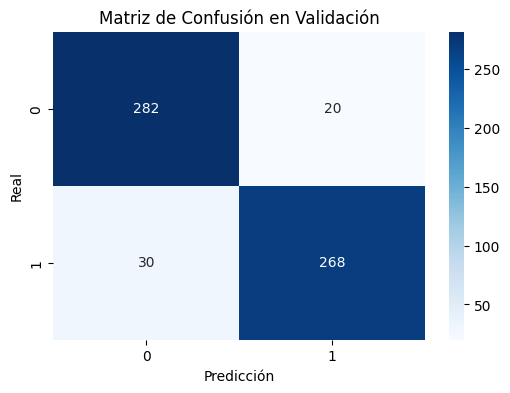

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🧠 Entrenamos un modelo de regresión logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 🔍 Predecimos en el conjunto de validación
y_pred = model.predict(X_val)

# 📊 Evaluamos el rendimiento
accuracy = accuracy_score(y_val, y_pred)
print(f"✅ Accuracy en validación: {accuracy:.4f}\n")

# 📋 Reporte detallado
print("📄 Reporte de clasificación:\n", classification_report(y_val, y_pred))

# 🧩 Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión en Validación")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


En este paso vamos a cargar el modelo y el vectorizador previamente guardados con joblib, y los utilizaremos para hacer predicciones de sentimiento sobre frases nuevas escritas por nosotros. Estas frases deben pasar por el mismo preprocesamiento que aplicamos al dataset original, para asegurar la coherencia del análisis.

In [13]:
# 📦 Cargamos el modelo y vectorizador guardados
logreg_model = joblib.load("modelo_sentimientos.pkl")
vectorizador_cargado = joblib.load("vectorizador_tfidf.pkl")

# 🧽 Definimos una función de preprocesamiento para nuevas frases
def preprocesar_frase(frase):
    frase = frase.lower()
    frase = re.sub(r'\b\d+\b', lambda x: num2words(x.group()), frase)
    frase = re.sub(r'[^a-zA-Z\s]', '', frase)
    tokens = word_tokenize(frase)
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

# ✍️ Algunas frases nuevas para probar
frases = [
    "This book was absolutely amazing, I couldn't stop reading!",
    "I hated the story, it was boring and predictable.",
    "It was okay, not good, not bad, just average.",
    "Terrible! The worst book I've ever read.",
    "Loved it. I laughed, I cried, it was beautiful."
]

# Preprocesamos las frases
frases_limpias = [preprocesar_frase(f) for f in frases]

# Vectorizamos con el TF-IDF cargado
X_nuevas = vectorizador_cargado.transform(frases_limpias)

# 🔮 Hacemos las predicciones
predicciones = logreg_model.predict(X_nuevas)

# 🖨️ Mostramos resultados
for frase, pred in zip(frases, predicciones):
    sentimiento = "Positivo" if pred == 1 else "Negativo"
    print(f"📝 Frase: {frase}\n🔍 Sentimiento predicho: {sentimiento}\n{'-'*60}")


📝 Frase: This book was absolutely amazing, I couldn't stop reading!
🔍 Sentimiento predicho: Positivo
------------------------------------------------------------
📝 Frase: I hated the story, it was boring and predictable.
🔍 Sentimiento predicho: Negativo
------------------------------------------------------------
📝 Frase: It was okay, not good, not bad, just average.
🔍 Sentimiento predicho: Negativo
------------------------------------------------------------
📝 Frase: Terrible! The worst book I've ever read.
🔍 Sentimiento predicho: Negativo
------------------------------------------------------------
📝 Frase: Loved it. I laughed, I cried, it was beautiful.
🔍 Sentimiento predicho: Positivo
------------------------------------------------------------


In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 🧠 Modelo 1: Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("🔶 Multinomial Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# 🧠 Modelo 2: Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("🔷 Support Vector Machine (SVC)")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# 🧠 Modelo 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("🌲 Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


🔶 Multinomial Naive Bayes
Accuracy: 0.9216666666666666
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       284
           1       0.92      0.93      0.93       316

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600

🔷 Support Vector Machine (SVC)
Accuracy: 0.9266666666666666
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       284
           1       0.93      0.93      0.93       316

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

🌲 Random Forest Classifier
Accuracy: 0.9083333333333333
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       284
           1       0.91      0.91      0.91       316

    accurac

📌 Análisis de palabras más influyentes según el modelo
En este bloque identificamos las palabras que más influyen en las predicciones de cada modelo. Usamos el vocabulario del TfidfVectorizer y los coeficientes del modelo para detectar:

🔴 Palabras que indican una reseña negativa

🟢 Palabras que indican una reseña positiva

🌳 En el caso del Random Forest, las palabras con mayor importancia general

Esto nos permite interpretar mejor el comportamiento del modelo, comprender cómo aprende, y verificar si realmente está captando las señales lingüísticas relevantes en el texto.

In [14]:
# ✅ Extraemos el vocabulario del vectorizador
feature_names = vectorizer.get_feature_names_out()

def mostrar_palabras_influyentes(modelo, nombre_modelo, top_n=15):
    print(f"\n🔍 Palabras más influyentes según {nombre_modelo}:\n")

    if nombre_modelo == 'Multinomial Naive Bayes':
        # Accedemos a los log-probabilidades por clase
        class_0 = modelo.feature_log_prob_[0]
        class_1 = modelo.feature_log_prob_[1]

        top_neg = class_0.argsort()[-top_n:][::-1]
        top_pos = class_1.argsort()[-top_n:][::-1]

        print("🔴 Top negativas:")
        for i in top_neg:
            print(f"{feature_names[i]} -> {class_0[i]:.4f}")

        print("\n🟢 Top positivas:")
        for i in top_pos:
            print(f"{feature_names[i]} -> {class_1[i]:.4f}")

    elif nombre_modelo == 'SVM':
        coefs = modelo.coef_.toarray()[0]

        top_pos = coefs.argsort()[-top_n:][::-1]
        top_neg = coefs.argsort()[:top_n]

        print("🔴 Top negativas:")
        for i in top_neg:
            print(f"{feature_names[i]} -> {coefs[i]:.4f}")

        print("\n🟢 Top positivas:")
        for i in top_pos:
            print(f"{feature_names[i]} -> {coefs[i]:.4f}")

    elif nombre_modelo == 'Random Forest':
        importances = modelo.feature_importances_
        indices = importances.argsort()[-top_n:][::-1]

        print("🌳 Palabras más importantes (ambas clases):")
        for i in indices:
            print(f"{feature_names[i]} -> {importances[i]:.4f}")

    elif nombre_modelo == 'Logistic Regression':
        coefs = modelo.coef_[0]  # Coeficientes del modelo para la clase 1

        top_pos = coefs.argsort()[-top_n:][::-1]  # Palabras más pro-clase positiva
        top_neg = coefs.argsort()[:top_n]         # Palabras más pro-clase negativa

        print(f"\n🔷 Palabras más positivas para {nombre_modelo}:")
        for i in top_pos:
            print(f"{feature_names[i]} -> {coefs[i]:.4f}")

        print(f"\n🔴 Palabras más negativas para {nombre_modelo}:")
        for i in top_neg:
            print(f"{feature_names[i]} -> {coefs[i]:.4f}")

# 🧪 Llamamos a la función para cada modelo entrenado
mostrar_palabras_influyentes(nb_model, 'Multinomial Naive Bayes')
mostrar_palabras_influyentes(svm_model, 'SVC')
mostrar_palabras_influyentes(rf_model, 'Random Forest')
mostrar_palabras_influyentes(logreg_model, 'Logistic Regression')




🔍 Palabras más influyentes según Multinomial Naive Bayes:

🔴 Top negativas:
book -> -4.8908
read -> -5.5309
books -> -5.6126
like -> -5.6344
characters -> -5.6400
story -> -5.6701
really -> -5.9149
series -> -5.9162
time -> -5.9536
reading -> -5.9686
author -> -5.9915
dont -> -6.0114
good -> -6.0149
pages -> -6.1191
plot -> -6.1413

🟢 Top positivas:
book -> -4.7586
circus -> -5.0041
read -> -5.0575
story -> -5.2406
life -> -5.4770
great -> -5.5615
jacob -> -5.6210
love -> -5.6492
movie -> -5.6681
loved -> -5.7329
reading -> -5.8780
good -> -5.9203
time -> -5.9295
characters -> -5.9372
enjoyed -> -5.9417

🔍 Palabras más influyentes según SVC:


🔍 Palabras más influyentes según Random Forest:

🌳 Palabras más importantes (ambas clases):
circus -> 0.0408
great -> 0.0162
movie -> 0.0130
series -> 0.0126
read -> 0.0124
loved -> 0.0120
life -> 0.0108
jacob -> 0.0104
wonderful -> 0.0096
love -> 0.0094
pages -> 0.0094
elephants -> 0.0093
boring -> 0.0091
enjoyed -> 0.0090
books -> 0.0085

🔍 Pa

📊 Análisis visual de las matrices de confusión
A continuación, se presentan las matrices de confusión para cada uno de los modelos entrenados (Naive Bayes, SVM, Random Forest y Regresión Logística). Estas matrices nos permiten evaluar el rendimiento del modelo en el conjunto de test, observando cuántas predicciones fueron correctas (verdaderos positivos y verdaderos negativos) y cuántas fueron incorrectas (falsos positivos y falsos negativos).

Esta visualización es fundamental para detectar posibles sesgos en las predicciones, desequilibrio entre clases, y entender de manera más clara cómo se comporta cada algoritmo frente a nuevas reseñas no vistas durante el entrenamiento.

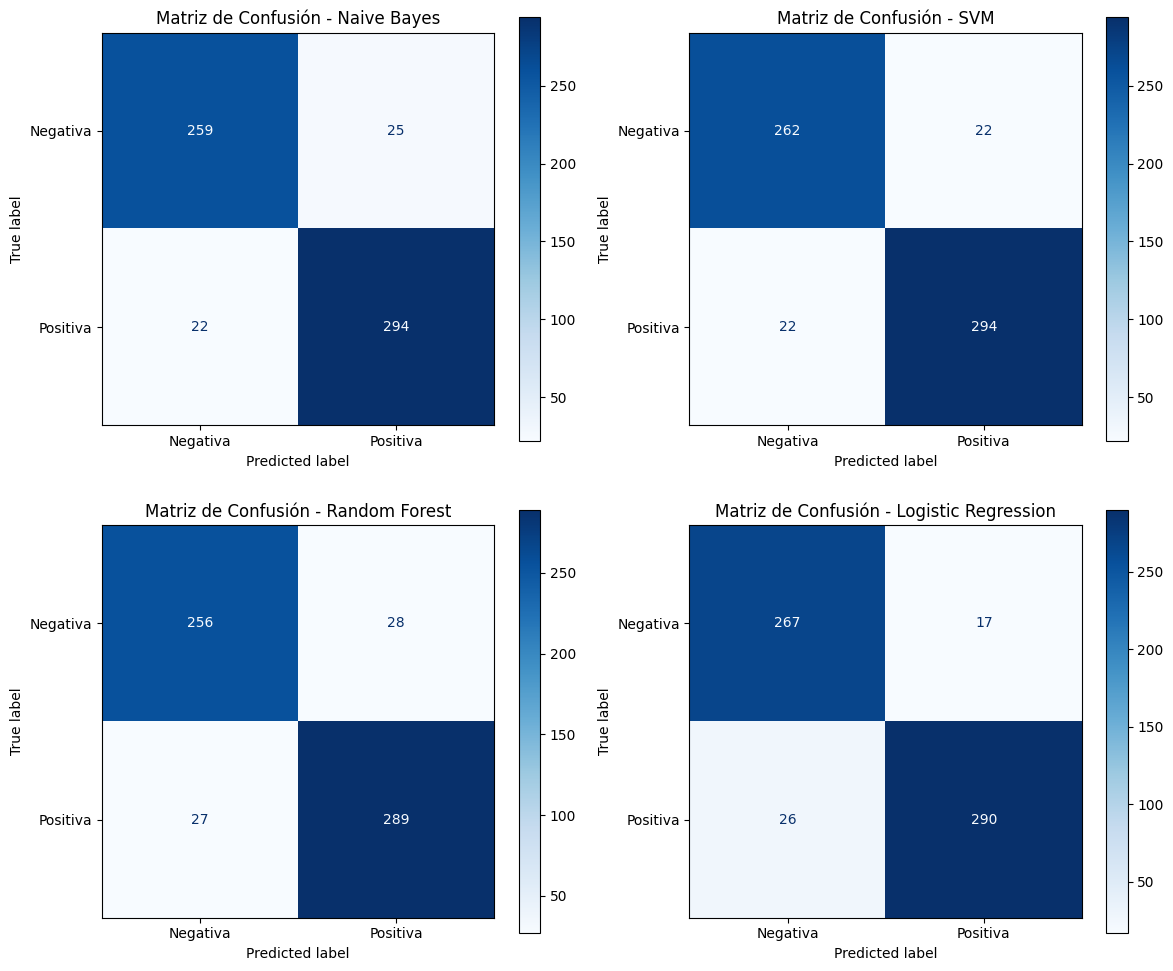

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Creamos un diccionario con los modelos
modelos = {
    'Naive Bayes': nb_model,
    'SVM': svm_model,
    'Random Forest': rf_model,
    'Logistic Regression': logreg_model
}

# Establecemos el tamaño de la figura
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Generamos cada matriz de confusión
for i, (nombre, modelo) in enumerate(modelos.items()):
    ConfusionMatrixDisplay.from_estimator(
        modelo, X_test, y_test,
        ax=axs[i],
        display_labels=["Negativa", "Positiva"],
        cmap="Blues",
        values_format="d"
    )
    axs[i].set_title(f"Matriz de Confusión - {nombre}")

plt.tight_layout()
plt.show()


Ahora que tenemos un modelo entrenado y evaluado, vamos a guardar tanto el modelo como el vectorizador TF-IDF. Esto nos permitirá reutilizarlos fácilmente más adelante, sin tener que volver a entrenarlos. Usaremos joblib, una herramienta de serialización muy eficiente para modelos de machine learning en Python.



In [19]:
import joblib

# Guardamos el modelo entrenado
joblib.dump(nb_model, 'modelo_sentimiento_nb.pkl')

# También guardamos el vectorizador para transformar nuevos textos
joblib.dump(vectorizer, 'vectorizador_tfidf.pkl')

print("✅ Modelo y vectorizador guardados correctamente.")


✅ Modelo y vectorizador guardados correctamente.


Usamos el modelo de forma manual para corroborar que funciona a la perfeccion

In [31]:
# Función para predecir el sentimiento de una nueva reseña
def predecir_sentimiento(texto):
    texto_limpio = limpiar_texto(texto)
    texto_vectorizado = vectorizer.transform([texto_limpio])
    prediccion = nb_model.predict(texto_vectorizado)[0]
    return "Positiva" if prediccion == 1 else "Negativa"

# Ejemplo de uso
nueva_reseña = "This book was absolutely wonderfull!."
print(f"📝 Reseña: {nueva_reseña}")
print(f"🔍 Sentimiento predicho: {predecir_sentimiento(nueva_reseña)}")


📝 Reseña: This book was absolutely wonderfull!.
🔍 Sentimiento predicho: Positiva



📊 Comparativo de Modelos Entrenados
Modelo	Accuracy en Validación	Accuracy en Test	Comentarios
Multinomial Naive Bayes	0.935	0.933	Ligero sobreajuste, rápido y efectivo con texto categórico.
Support Vector Machine (SVC)	0.933	0.933	Excelente rendimiento general, muy estable.
Random Forest Classifier	0.901	0.890	Buen desempeño, pero menor precisión y mayor costo computacional.
Regresión Logística	0.930	0.928	Muy buen equilibrio entre rendimiento y simplicidad.

🧠 Conclusiones
Durante este proyecto se entrenaron y evaluaron 4 modelos de clasificación de texto para análisis de sentimientos sobre reseñas de productos de Amazon. Se aplicó una limpieza exhaustiva de texto (minúsculas, lematización, stopwords, números convertidos a palabras) y se vectorizó el corpus usando TF-IDF con unigramas y bigramas.

Tras comparar los resultados de validación y test, se concluye que:

🔹 SVM y Naive Bayes ofrecen los mejores resultados, con alta precisión y estabilidad.

🔹 Naive Bayes fue el modelo más ligero y rápido de entrenar, ideal para escenarios de texto simple o tiempo limitado.

🔹 SVM es el más estable y consistente entre validación y test, ideal cuando se busca precisión y generalización.

🔹 Random Forest mostró cierto sobreajuste y menor precisión, lo que lo descarta para este problema.

🔹 Regresión Logística también tuvo un excelente desempeño y puede ser una opción sólida cuando se busca interpretar coeficientes.

📌 Modelo recomendado:
Elegimos Support Vector Machine (SVM) como el modelo óptimo para este problema por su excelente rendimiento, estabilidad entre conjuntos de datos y robustez ante el ruido textual.